##### instruction for properly installing tensorflow 2.9.1 for Mac with GPU support
- conda install -c apple tensorflow-deps

-  Install specific TensorFlow version for Mac
python -m pip install tensorflow-macos==2.9.1

-  Install Metal plugin for GPU support
python -m pip install tensorflow-metal==0.5.0


- previous pytorch versions[https://pytorch.org/get-started/previous-versions/]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.applications.xception import decode_predictions

%matplotlib inline

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
learning_rate=0.001
size = 50
drop = 0.2
input_size = 299

In [5]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range= 10.0,
    zoom_range = 0.1,
    vertical_flip = True)


train_ds = train_gen.flow_from_directory('../train', 
                                         target_size=(input_size,input_size), 
                                         batch_size=32)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

valid_ds = valid_gen.flow_from_directory('../validation', 
                                         target_size=(input_size,input_size), 
                                         batch_size=32, shuffle=False)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [6]:
checkpointing = keras.callbacks.ModelCheckpoint(
    "xception_v5.2_bigger_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

In [7]:
def make_model(input_size = 150, learning_rate=0.01, inner_size=50,dropout_rate = 0.2):
    base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size,input_size,3),
    )
    
    base_model.trainable = False
    #########################################
    inputs = keras.Input(shape=(input_size,input_size,3))
    base = base_model(inputs, training =False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(inner_size, activation='relu')(vectors)
    dropout = keras.layers.Dropout(dropout_rate)(inner)
    outputs = keras.layers.Dense(10)(dropout)
    model = keras.Model(inputs, outputs)
    #################################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics = ['accuracy'])

    return model

In [ ]:
learning_rate=0.001
size = 50
drop = 0.2
input_size = 299
    
model = make_model(learning_rate=learning_rate, 
                   inner_size = size, 
                   dropout_rate=drop,
                   input_size=299)
training_history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpointing])

Metal device set to: Apple M1


2024-11-06 13:57:08.719773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-06 13:57:08.720502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2024-11-06 13:57:11.008246: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-06 13:57:12.940853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.5834

2024-11-06 14:00:24.629234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


96/96 [==============================] - 212s 2s/step - loss: 1.2722 - accuracy: 0.5834 - val_loss: 0.6513 - val_accuracy: 0.7859
Epoch 2/30
96/96 [==============================] - 192s 2s/step - loss: 0.7883 - accuracy: 0.7415 - val_loss: 0.5541 - val_accuracy: 0.8123
Epoch 3/30
96/96 [==============================] - 195s 2s/step - loss: 0.6787 - accuracy: 0.7810 - val_loss: 0.4880 - val_accuracy: 0.8358
Epoch 4/30
96/96 [==============================] - 193s 2s/step - loss: 0.6033 - accuracy: 0.7930 - val_loss: 0.4541 - val_accuracy: 0.8328
Epoch 5/30
96/96 [==============================] - 284s 3s/step - loss: 0.5584 - accuracy: 0.8211 - val_loss: 0.4419 - val_accuracy: 0.8240
Epoch 6/30
96/96 [==============================] - 212s 2s/step - loss: 0.5250 - accuracy: 0.8292 - val_loss: 0.4465 - val_accuracy: 0.8416
Epoch 7/30
96/96 [==============================] - 208s 2s/step - loss: 0.4864 - accuracy: 0.8390 - val_loss: 0.4397 - val_accuracy: 0.8358
Epoch 8/30
96/96 [======

In [ ]:
#plt.plot(training_history.history['accuracy'], label = 'train')
plt.plot(training_history.history['val_accuracy'], label = 'val')
plt.xticks(np.arange(20))

plt.legend()

### Loading and Testing Model

In [27]:
model = keras.models.load_model("xception_v5.1_bigger_06_0.880.h5")

In [28]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory('../test', 
                                         target_size=(input_size,input_size), 
                                         batch_size=32, 
                                         shuffle=False)

Found 372 images belonging to 10 classes.


In [29]:
model.evaluate(test_ds)

2024-11-05 18:53:28.815334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 20s 2s/step - loss: 0.2704 - accuracy: 0.9059


[0.2704275846481323, 0.9059139490127563]

### testing image

In [11]:
!pwd

/Users/mtm007/Downloads/new_keras/Deploy_DL/nb


In [ ]:
current_dir = !pwd
path = current_dir[0]+"/test/outwear/8f8c07c7-b289-41eb-ac43-9bfb8863e0cb.jpg"

In [30]:
path = "../test/outwear/8f8c07c7-b289-41eb-ac43-9bfb8863e0cb.jpg"

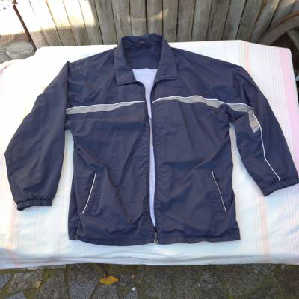

In [31]:
img = load_img(path, target_size=(299,299))
img

In [32]:
x = np.array(img)
x = np.array([x])
x = preprocess_input(x)
x.shape


(1, 299, 299, 3)

In [33]:
pred = model.predict(x)

2024-11-05 18:53:53.531719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 955ms/step


In [34]:
classes = [
    'dress',
     'hat',
     'longsleeve',
     'outwear',
     'pants',
     'shirt',
     'shoes',
     'shorts',
     'skirt']

In [35]:
dict(zip(classes,pred[0]))

{'dress': -2.0582492,
 'hat': -6.791645,
 'longsleeve': 5.059049,
 'outwear': 2.6540136,
 'pants': -2.1473649,
 'shirt': 2.9174528,
 'shoes': -9.192068,
 'shorts': -1.0183942,
 'skirt': -4.9148693}